# Optimise on a big dataframe

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [3]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

In [145]:
# Create an empty df
master_df_H = pd.DataFrame()
master_df_V = pd.DataFrame()

# First data measurement

Text(0.5, 1.0, 'Beam size')

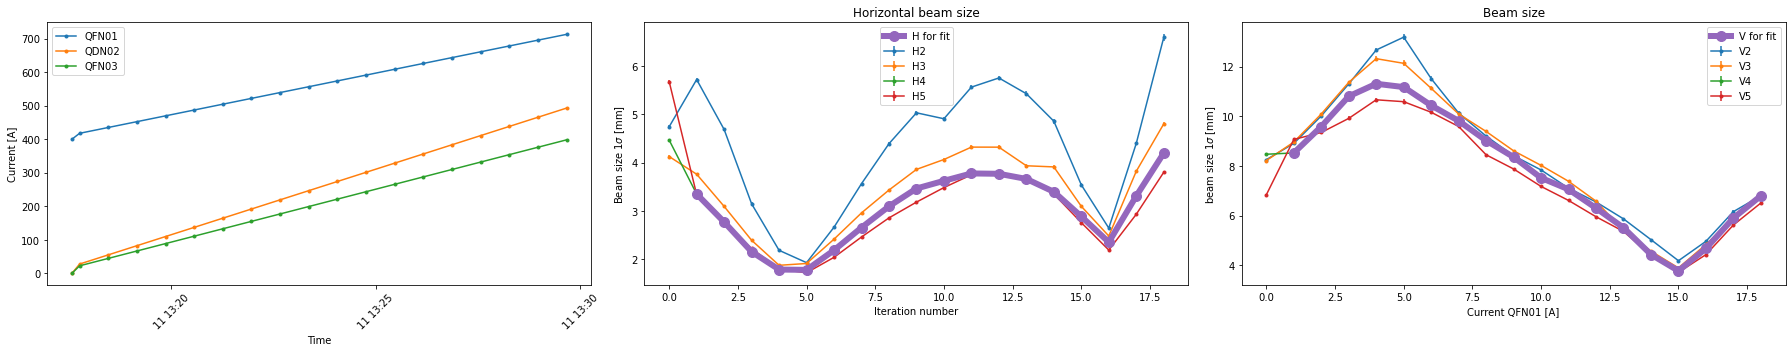

In [146]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[0]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Second data measurement

Text(0.5, 1.0, 'Beam size')

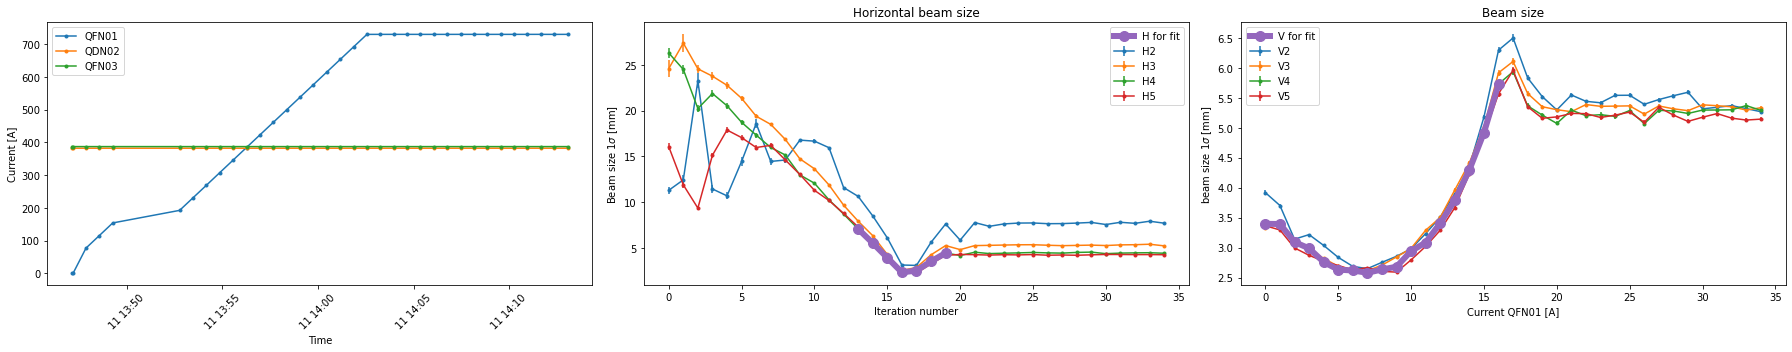

In [147]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[1]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [13,len(acquisition)-15]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-18]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Third Measurement

Text(0.5, 1.0, 'Beam size')

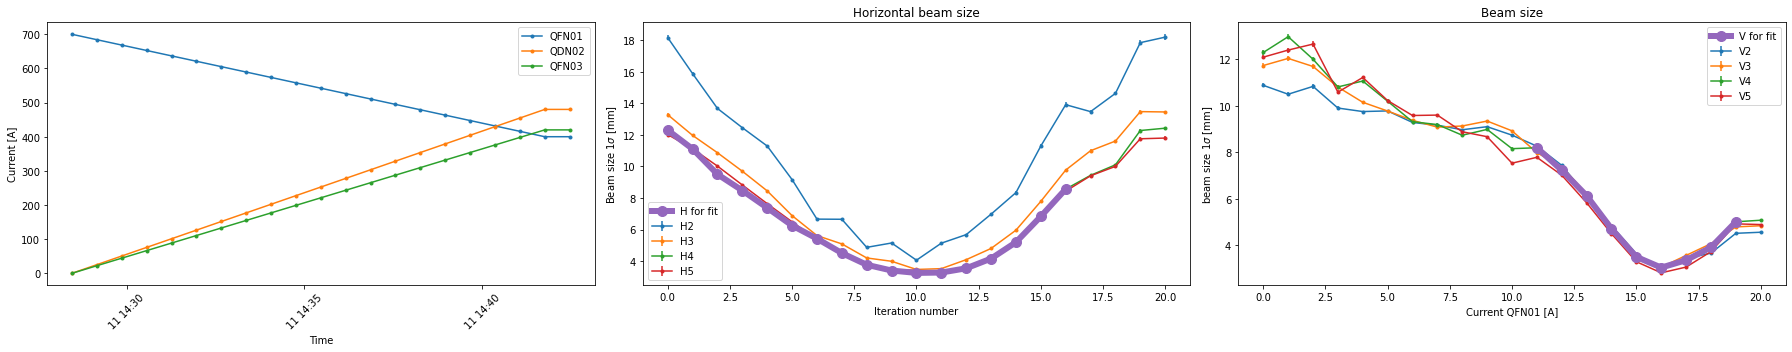

In [148]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[2]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-4]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [11,len(acquisition)-1]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

# Fourth measurement

In [149]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[3]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-0]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-6]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

Text(0.5, 1.0, 'Beam size')

# Fifth measurement

In [150]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[4]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (25,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-17]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-7]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Current QFN01 [A]")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

Text(0.5, 1.0, 'Beam size')

Text(0.5, 1.0, 'Multi Quad Scan BTV010')

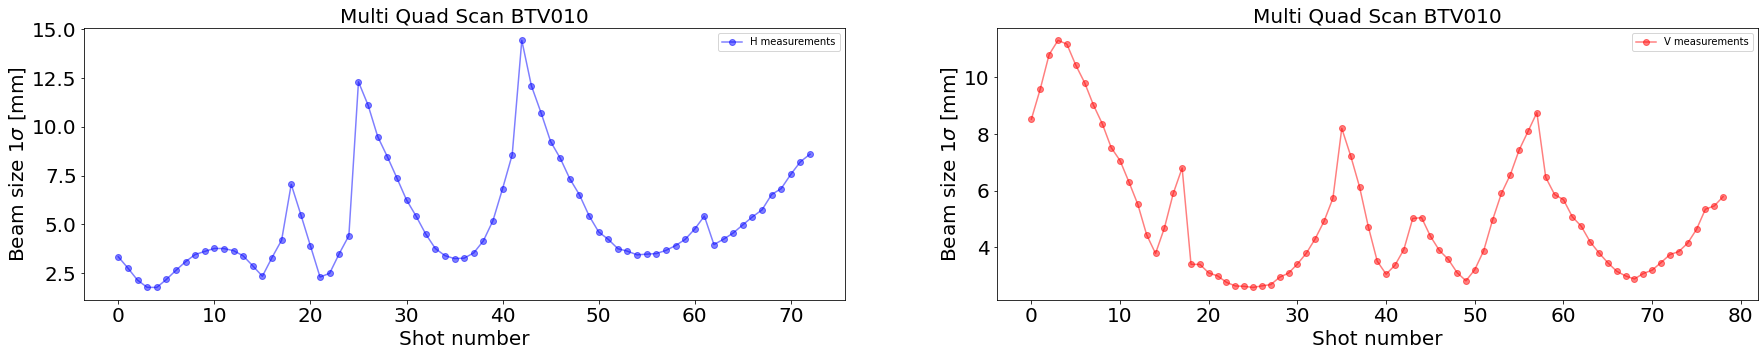

In [151]:
fig, ax = plt.subplots(1,2, figsize=(30,5))

x_axis_total_H = np.linspace(0,len(master_df_H.sigma_H)-1, len(master_df_H.sigma_H))
ax[0].plot(x_axis_total_H, master_df_H.sigma_H, color = "b", alpha=0.5, marker = "o", label = "H measurements")

ax[0].legend()
ax[0].set_xlabel("Shot number", fontsize=20)
ax[0].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].set_title("Multi Quad Scan BTV010", fontsize = 20)

x_axis_total_V = np.linspace(0,len(master_df_V.sigma_V)-1, len(master_df_V.sigma_V))

ax[1].plot(x_axis_total_V, master_df_V.sigma_V, color = "r",  alpha=0.5, marker = "o", label = "V measurements")

ax[1].legend()
ax[1].set_xlabel("Shot number", fontsize=20)
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].set_title("Multi Quad Scan BTV010", fontsize = 20)

# Try to speed MADX up

In [11]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [12]:
# New initial conditions East Area
betx0 = 8.03942769e+01
bety0 = 2.09833303e+00
alfx0 = -1.25041716e+01
alfy0 = -1.11553173e-01
Dx0 = -5.20554087e+00
Dy0 = -1.00223341e+00
Dpx0 = -1.34656718e+00
Dpy0 = -8.72632488e-02
exn = 1.48924155e-06
eyn = 1.51732434e-06
sige = 7.47249503e-04

In [104]:
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  

madx.use(sequence="f61d")

In [105]:
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

# Compare the horizontal beam sizes
H_sigma_madx = []

for i in range(len(master_df_H)):
    quad_current["QFN01"] = master_df_H.qfn01_current[i]
    quad_current["QDN02"] = master_df_H.qdn02_current[i]
    quad_current["QFN03"] = master_df_H.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )

deltaH = abs(master_df_H.sigma_H - np.array(H_sigma_madx)*1000)

objective = sum(deltaH)
print (objective)

87.137872741302


In [ ]:
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))

In [155]:
from multiprocessing import Pool
import pandas as pd

def get_price(idx, row):
    # logic to fetch price
    return idx, price

def main():
    df = pd.read_csv("path to file")
    NUM_OF_WORKERS = 2 
    pool = Pool(NUM_OF_WORKERS)
    results = [pool.apply_async(get_price, [idx, row]) for idx, row in df.iterrows()]
    for result in results:
        idx, price = result.get()
        df.loc[idx, 'Price'] = price
    # do whatever you want to do with df, save it to same file.

if __name__ == "__main__":
    # don't forget to call main func as module
    # This is must in windows use multiple processes/threads. It's also a good practice, more info on this page https://docs.python.org/3/library/multiprocessing.html#multiprocessing-programming
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'path to file'

In [63]:
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
madx = Madx()
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  

madx.use(sequence="f61d")

In [68]:
from multiprocessing import Pool
import pandas as pd

#################################### Initialize MADX ####################################
madx = Madx()
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  

madx.use(sequence="f61d")

### START MULTIPROCESS ###
def calculate_beam_size(idx, row):  
    
    c1 = master_df_H.qfn01_current.iloc[idx]
    c2 = master_df_H.qdn02_current.iloc[idx]
    c3 = master_df_H.qfn03_current.iloc[idx]
    
#     quad_current["QFN01"] = master_df_H.qfn01_current[i]
#     quad_current["QDN02"] = master_df_H.qdn02_current[i]
#     quad_current["QFN03"] = master_df_H.qfn03_current[i]

#     madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
#     madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
#     madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

#     twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    
#     sigma = beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1)
    
    return idx, c1, c2, c3

def main():
    pool = Pool(8)
    results = [pool.apply_async(calculate_beam_size, [idx, row]) for idx, row in master_df_H.iterrows()]
    for result in results:
        idx, c1, c2, c3 = result.get()
        master_df_H.loc[idx, 'c1'] = c1
        master_df_H.loc[idx, 'c2'] = c2
        master_df_H.loc[idx, 'c3'] = c3


if __name__ == "__main__":
    main()

UnpicklingError: unpickling stack underflow

Process ForkPoolWorker-63:
Process ForkPoolWorker-69:
Process ForkPoolWorker-67:
Process ForkPoolWorker-62:
Process ForkPoolWorker-65:
Process ForkPoolWorker-66:
Traceback (most recent call last):
Process ForkPoolWorker-68:
Process ForkPoolWorker-64:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-

# Yann's method

In [16]:
from functools import partial
from cpymad import libmadx
import time
from multiprocessing import Pool

In [17]:
mqk = 1.0 
mql = 0.1 
length = 5.3
pc = 1000
madx = None

In [18]:
btv="f61.btv010"
def multimad(idx, start_time):
    global madx
    if not madx:
        print('initializing madx, time is', time.time()-start_time)
        madx = Madx()
        madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
        madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
        madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
        madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

        madx.input('SEQEDIT, SEQUENCE=f61d;')
        madx.input('FLATTEN;')
        madx.input('REMOVE, ELEMENT=ARBMATRIX;')
        madx.input('FLATTEN;')
        madx.input('ENDEDIT;')

        madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')

        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  

        madx.use(sequence="f61d")
    else:
        print('no need, madx is already initialized ! time is', time.time()-start_time)
        
    c1 = master_df_H.qfn01_current[idx]
    c2 = master_df_H.qdn02_current[idx]
    c3 = master_df_H.qfn03_current[idx]

    madx.input("kQFN1 = "+str(interpolate_gradient(c1, "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(c2, "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(c3, "QFL")/(quad_length["QFN03"]*Brho))+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )

    return idx, c1, c2, c3, H_sigma_madx

In [20]:
start_time = time.time()

with Pool(4) as p:
    results = p.map(partial(multimad, start_time=start_time),
                    np.arange(0, len(master_df_H), 1))
    for result in results:
        idx, c1, c2, c3, H_sigma_madx = result
        master_df_H.loc[idx, 'c1'] = c1
        master_df_H.loc[idx, 'c2'] = c2
        master_df_H.loc[idx, 'c3'] = c3
        master_df_H.loc[idx, 'H_sigma_madx'] = H_sigma_madx*1000

initializing madx, time isinitializing madx, time isinitializing madx, time isinitializing madx, time is   0.04369401931762695 0.044581413269042970.043931722640991210.04404759407043457



no need, madx is already initialized ! time is 2.4427967071533203no need, madx is already initialized ! time is
 2.449289560317993
no need, madx is already initialized ! time is 2.478483200073242
no need, madx is already initialized ! time is 2.4875283241271973
no need, madx is already initialized ! time is 2.510657548904419no need, madx is already initialized ! time is
 2.531468629837036
no need, madx is already initialized ! time is 2.5600366592407227
no need, madx is already initialized ! time is 2.588170051574707
no need, madx is already initialized ! time is 2.613328218460083
no need, madx is already initialized ! time is 2.63537335395813
no need, madx is already initialized ! time is 2.6549458503723145
no need, madx is already initialized ! time is 2.678290605545044
no need, madx is already init

In [65]:
master_df_H

qfn01_current  qdn02_current  qfn03_current   sigma_H          c1  \
0      417.361633      27.367531      22.107521  3.347886  417.361633   
1      434.729889      54.739098      44.213318  2.768039  434.729889   
2      452.095642      82.103271      66.314667  2.152965  452.095642   
3      469.465637     109.473686      88.420662  1.784178  469.465637   
4      486.834717     136.838013     110.525337  1.777175  486.834717   
..            ...            ...            ...       ...         ...   
75     576.300293     381.998779     386.999115  3.904297  576.300293   
76     614.726318     382.002441     387.001221  2.308636  614.726318   
77     653.149170     382.002716     386.999695  2.501446  653.149170   
78     691.554077     382.000427     386.997131  3.508695  691.554077   
79     729.896667     382.000610     386.999146  4.425737  729.896667   

            c2          c3  H_sigma_madx  
0    27.367531   22.107521      4.810875  
1    54.739098   44.213318      4.466780  
2    82.103271   66.314667      4.249028  
3   109.473686   88.420662      4.173745  
4   136.838013  110.525337      4.233349  
..         ...         ...           ...  
75  381.998779  386.999115      4.310443  
76  382.002441  387.001221      3.720693  
77  382.002716  386.999695      3.810298  
78  382.000427  386.997131      4.362021  
79  382.000610  386.999146      5.111232  

[80 rows x 8 columns]

Text(0.01, 0.6, 'Rematched initial parameters:\n$\\beta_{x}$=80.3942769\n$\\beta_{y}$=2.09833303\n$\\alpha_{x}$=-12.5041716\n$\\alpha_{y}$=-0.111553173\n$D_{x}$=-5.20554087\n$D_{y}$=-1.00223341\n$D_{px}$=-1.34656718\n$D_{py}$=-0.0872632488')

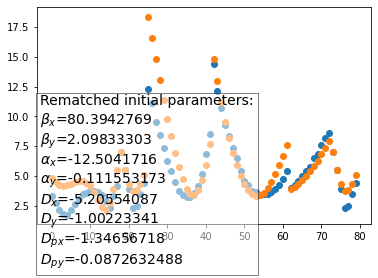

In [78]:
fig, ax = plt.subplots()
ax.scatter(x_axis_total_H, master_df_H.sigma_H)
ax.scatter(x_axis_total_H, master_df_H.H_sigma_madx)

textstr = '\n'.join((
    "Rematched initial parameters:",
    r'$\beta_{x}$='+str(betx0),
    r'$\beta_{y}$='+str(bety0),
    r'$\alpha_{x}$='+str(alfx0),
    r'$\alpha_{y}$='+str(alfy0),
    r'$D_{x}$='+str(Dx0),
    r'$D_{y}$='+str(Dy0),
    r'$D_{px}$='+str(Dpx0),
    r'$D_{py}$='+str(Dpy0),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.01, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Method with 4 workers (4 instances of madx)

In [44]:
import multiprocessing 
import os 

my_df = pd.DataFrame()

def worker1():
    global my_df
    print("ID of worker1: {}".format(os.getpid())) 
    i=0
    for i in range(100000000):
        i += 1
    print("ID 1 finished !")
    return i
def worker2():
    global my_df
    print("ID of worker2: {}".format(os.getpid()))
    i=0
    for i in range(20000000):
       i += 1 
    print("ID 2 finished !")
    return i
if __name__ == "__main__": 
    print("ID of main process: {}".format(os.getpid())) 
    p1 = multiprocessing.Process(target=worker1) 
    p2 = multiprocessing.Process(target=worker2) 
    p1.start() 
    p2.start()
    print("ID of process p1: {}".format(p1.pid)) 
    print("ID of process p2: {}".format(p2.pid))  
    p1.join()
    p2.join()
    print("processes finished execution!") 
    print("Process p1 is alive: {}".format(p1.is_alive())) 
    print("Process p2 is alive: {}".format(p2.is_alive())) 

ID of main process: 690
ID of worker1: 2384
ID of worker2: 2388
ID of process p1: 2384
ID of process p2: 2388
ID 2 finished !
ID 1 finished !
processes finished execution!
Process p1 is alive: False
Process p2 is alive: False


In [58]:
master_df_H_copy = master_df_H.copy()
master_df_H_copy

qfn01_current  qdn02_current  qfn03_current   sigma_H          c1  \
0      417.361633      27.367531      22.107521  3.347886  417.361633   
1      434.729889      54.739098      44.213318  2.768039  434.729889   
2      452.095642      82.103271      66.314667  2.152965  452.095642   
3      469.465637     109.473686      88.420662  1.784178  469.465637   
4      486.834717     136.838013     110.525337  1.777175  486.834717   
..            ...            ...            ...       ...         ...   
68     468.412109     370.525482     331.051880  6.529440  468.412109   
69     463.150635     378.944794     337.893738  6.836204  463.150635   
70     457.886230     387.369080     344.736755  7.566044  457.886230   
71     452.620361     395.788513     351.578064  8.209173  452.620361   
72     447.362457     404.209747     358.419678  8.597919  447.362457   

            c2          c3  H_sigma_madx  
0    27.367531   22.107521      4.827945  
1    54.739098   44.213318      4.476663  
2    82.103271   66.314667      4.253085  
3   109.473686   88.420662      4.174418  
4   136.838013  110.525337      4.233471  
..         ...         ...           ...  
68  370.525482  331.051880      5.873447  
69  378.944794  337.893738      6.352062  
70  387.369080  344.736755      6.875295  
71  395.788513  351.578064      7.438528  
72  404.209747  358.419678      8.012172  

[73 rows x 8 columns]

In [68]:
np.array_split(master_df_H_copy, 4)[0]

qfn01_current  qdn02_current  qfn03_current   sigma_H          c1  \
0      417.361633      27.367531      22.107521  3.347886  417.361633   
1      434.729889      54.739098      44.213318  2.768039  434.729889   
2      452.095642      82.103271      66.314667  2.152965  452.095642   
3      469.465637     109.473686      88.420662  1.784178  469.465637   
4      486.834717     136.838013     110.525337  1.777175  486.834717   
5      504.202271     164.206024     132.627808  2.184337  504.202271   
6      521.572144     191.577667     154.734192  2.653182  521.572144   
7      538.942505     218.945129     176.838501  3.093342  538.942505   
8      556.308350     246.319824     198.946350  3.461949  556.308350   
9      573.675537     273.684509     221.053528  3.621215  573.675537   
10     591.035278     301.052429     243.157745  3.774052  591.035278   
11     608.408569     328.420837     265.265442  3.766856  608.408569   
12     625.775635     355.791565     287.367950  3.660155  625.775635   
13     643.145325     383.158417     309.470581  3.394068  643.145325   
14     660.522583     410.523224     331.575012  2.882512  660.522583   
15     677.883667     437.894409     353.682129  2.350578  677.883667   
16     695.217163     465.264587     375.789917  3.306913  695.217163   
17     712.555420     492.628418     397.889526  4.195321  712.555420   
18     499.467590     382.001160     387.000061  7.051747  499.467590   

            c2          c3  H_sigma_madx  
0    27.367531   22.107521      4.827945  
1    54.739098   44.213318      4.476663  
2    82.103271   66.314667      4.253085  
3   109.473686   88.420662      4.174418  
4   136.838013  110.525337      4.233471  
5   164.206024  132.627808      4.375812  
6   191.577667  154.734192      4.523968  
7   218.945129  176.838501      4.631770  
8   246.319824  198.946350      4.631264  
9   273.684509  221.053528      4.475409  
10  301.052429  243.157745      4.162242  
11  328.420837  265.265442      3.677261  
12  355.791565  287.367950      3.058092  
13  383.158417  309.470581      2.435059  
14  410.523224  331.575012      2.167084  
15  437.894409  353.682129      2.716961  
16  465.264587  375.789917      3.915165  
17  492.628418  397.889526      5.542980  
18  382.001160  387.000061      7.106167

In [ ]:
import multiprocessing

madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")



def worker1(df, return_dict):
    print("ID of worker1: {}".format(os.getpid())) 
    i = 0
    for idx in list(df.index.values):
        c1 = df.qfn01_current[idx]
        c2 = df.qdn02_current[idx]
        c3 = df.qfn03_current[idx]

        madx1.input("kQFN1 = "+str(interpolate_gradient(c1, "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx1.input("kQDN2 = "+str(-interpolate_gradient(c2, "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx1.input("kQFN3 = "+str(interpolate_gradient(c3, "QFL")/(quad_length["QFN03"]*Brho))+";")

        twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    
        return_dict[i] = H_sigma_madx
        i += 1
        
        
def worker2(df, return_dict):
    print("ID of worker2: {}".format(os.getpid()))
    i = 0
    for idx in list(df.index.values):
        c1 = df.qfn01_current[idx]
        c2 = df.qdn02_current[idx]
        c3 = df.qfn03_current[idx]

        madx2.input("kQFN1 = "+str(interpolate_gradient(c1, "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx2.input("kQDN2 = "+str(-interpolate_gradient(c2, "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx2.input("kQFN3 = "+str(interpolate_gradient(c3, "QFL")/(quad_length["QFN03"]*Brho))+";")

        twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    
        return_dict[i] = H_sigma_madx
        i += 1
        
def worker3(df, return_dict):
    print("ID of worker3: {}".format(os.getpid()))
    i = 0
    for idx in list(df.index.values):
        c1 = df.qfn01_current[idx]
        c2 = df.qdn02_current[idx]
        c3 = df.qfn03_current[idx]

        madx3.input("kQFN1 = "+str(interpolate_gradient(c1, "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx3.input("kQDN2 = "+str(-interpolate_gradient(c2, "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx3.input("kQFN3 = "+str(interpolate_gradient(c3, "QFL")/(quad_length["QFN03"]*Brho))+";")

        twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    
        return_dict[i] = H_sigma_madx
        i += 1
        
def worker4(df, return_dict):
    print("ID of worker4: {}".format(os.getpid()))
    i = 0
    for idx in list(df.index.values):
        c1 = df.qfn01_current[idx]
        c2 = df.qdn02_current[idx]
        c3 = df.qfn03_current[idx]

        madx4.input("kQFN1 = "+str(interpolate_gradient(c1, "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx4.input("kQDN2 = "+str(-interpolate_gradient(c2, "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx4.input("kQFN3 = "+str(interpolate_gradient(c3, "QFL")/(quad_length["QFN03"]*Brho))+";")

        twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    
        return_dict[i] = H_sigma_madx
        i += 1
        
if __name__ == "__main__":
    manager = multiprocessing.Manager()
    return_dict1 = manager.dict()
    return_dict2 = manager.dict()
    return_dict3 = manager.dict()
    return_dict4 = manager.dict()
    jobs = []
    p1 = multiprocessing.Process(target=worker1, args=(np.array_split(master_df_H_copy, 4)[0], return_dict1))
    p2 = multiprocessing.Process(target=worker2, args=(np.array_split(master_df_H_copy, 4)[1], return_dict2))
    p3 = multiprocessing.Process(target=worker3, args=(np.array_split(master_df_H_copy, 4)[2], return_dict3))
    p4 = multiprocessing.Process(target=worker4, args=(np.array_split(master_df_H_copy, 4)[3], return_dict4))
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    madx_sigma_list = []
    madx_sigma_list.extend(return_dict1.values())
    madx_sigma_list.extend(return_dict2.values())
    madx_sigma_list.extend(return_dict3.values())
    madx_sigma_list.extend(return_dict4.values())
    print ("Finished !")
    master_df_H["sigma_H_madx"]=madx_sigma_list
    master_df_H["delta_sigma_squared"] = abs(master_df_H["sigma_H_madx"]-master_df_H["sigma_H"])**2

